In [1]:
import numpy as np
import scipy.optimize as optimize
from matplotlib import pyplot as plt 

# Inputs

In [2]:
G = 70 #gap distance in meters
m = 90 #weight of slackliner
pretension = 3 #in kN
g = 9.81 #in m/(s^2)
stretch_at_ten = 20 #percent stretch at 10kN
stretch_at_five = 15 #percent stretch at 5kN

#first calculations
#epsilon0 = stretch_at_ten/(100*10) #stretch with unit 1/kN
epsilon0 = stretch_at_five/(100*5) #stretch with unit 1/kN
L0_pretension = G/(pretension*epsilon0+1)

# Defining important functions

In [3]:
#find sag
def eq(sag):
    return ((G+2/g*sag**2)/L0_pretension -1)/epsilon0*1000-m*g*G/4/sag
s=optimize.newton(eq, 0.5)

#functions
def L(sag): #length of the stretched webbing at sag
    return 2*np.sqrt((G/2)**2+sag**2)

def stretch(force): #values between 0 and 1, stretch at force 
    return epsilon0 * force

def force_at_rest(sag):  #in kN
    return m*g*G/(4*sag*1000)
    
L0=L(s)/(1+epsilon0*force_at_rest(s))

    #what i did here didn't work, start ignoring
def force_wrong(displacement): #vertical force on the slackliner around the resting sag computed from energy
    return ((s+displacement)/epsilon0)*(1/L0 - 1/(L(s+displacement))) 
def energy_in_webbing(sag):
    return ((L(sag)-L0)*L(sag)/L0)/(2*epsilon0)
k_wrong = (1/L0 - 1/L(s))/epsilon0 + (s/epsilon0)*(4*s/(L(s)**3))
    #end ignoring

def force(displacement): #in kN, vertical force on the slackliner around the resting sag computed from energy
    return 4*(s+displacement)/G*(L(s+displacement)/L0 - 1)/epsilon0


k = 1000*4/epsilon0/G*(L(s)/L0-1+s**2/L(s)/L0) #in N/m
T = 2*np.pi*np.sqrt(m/k)

# Stress-strain relationship

In [4]:
def sigma_linear(epsilon): #static stress strain curve
    return 10*epsilon/stretch_at_ten

def sigma_tanh(epsilon,bs,delta,mod): #eq (6) in https://www.sciencedirect.com/science/article/pii/S0020768309001000
    return bs*np.tanh((2-np.exp(-(delta*epsilon*mod/bs)**2/2))*epsilon*mod/bs)

In [5]:
sigma_tanh(10,30,0,1)

9.64538212594903

# Forces in the line (gravity vs. stretch)
plot of the static forces in the line (gravity vs. stretch), the lines intersect at the resting sag
this is how we find the resting sag for a given pretension

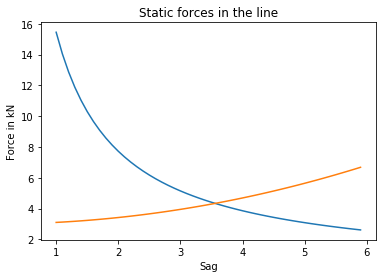

In [6]:
points=10
x = np.arange(1*points,6*points)
y1 = m*g*G/4/(x/points)/1000
y2 = ((G+2/g*(x/points)**2)/L0_pretension -1)/epsilon0
plt.title("Static forces in the line") 
plt.xlabel("Sag")
plt.ylabel("Force in kN") 
plt.plot(x/points,y1) 
plt.plot(x/points,y2) 
plt.show()

# Forces on the slackliner
 plot of the forces on the slackliner comparing the linear approximation of F(s) with the nonlinear function

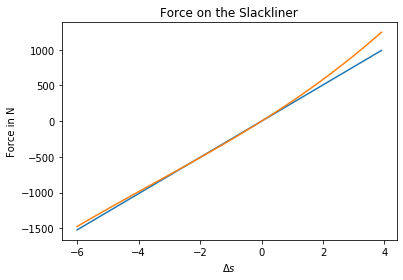

In [7]:
points=10
x = np.arange(-6*points,4*points)
y1 = k*(x/points)
y2= 1000*(force(x/points)-force(0))
plt.title("Force on the Slackliner") 
plt.xlabel("$\Delta s$") 
plt.ylabel("Force in N") 
plt.plot(x/points,y1) 
plt.plot(x/points,y2) 
plt.show()

# Finding Tops and Bottoms
Using the results about the forces on the slackliner above we define a top and a bottom of the bounce. One measure we can define is when the force exceeds $F_G$ in either direction

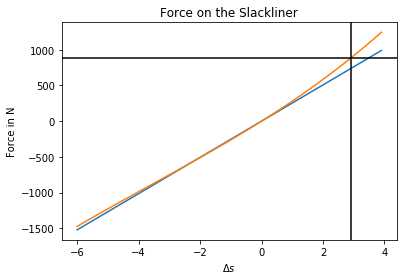

In [8]:
def bottom(sag):#should be zero when force =  mg
    return 1000*(force(sag-s)-force(0))- m*g
bot=optimize.newton(bottom, 2*s)

points=10
x = np.arange(-6*points,4*points)
y1 = k*(x/points)
y2= 1000*(force(x/points)-force(0))
plt.title("Force on the Slackliner") 
plt.xlabel("$\Delta s$") 
plt.ylabel("Force in N") 
plt.plot(x/points,y1) 
plt.plot(x/points,y2) 
plt.axvline(x=bot-s, color='black', linestyle='-')
plt.axhline(y=m*g, color='black', linestyle='-')

plt.show()

# Pumping

### Mechanical oscillator

The case of the one dimensional mechanical oscillator leads to the following equation:

$$
m \ddot x + \mu \dot x + k x = m \ddot x_d
$$

Where:

* $x$ is the position,
* $\dot x$ and $\ddot x$ are respectively the speed and acceleration,
* $m$ is the mass,
* $\mu$ the 
* $k$ the stiffness,
* and $\ddot x_d$ the driving acceleration which is null if the oscillator is free.

### Canonical equation

Most 1D oscilators follow the same canonical equation:

$$
\ddot x + 2 \zeta \omega_0 \dot x + \omega_0^2 x = \ddot x_d
$$

Where:

* $\omega_0$ is the undamped pulsation,
* $\zeta$ is damping ratio,
* $\ddot x_d = a_d\sin(\omega_d t)$ is the imposed acceleration.

In the case of the mechanical oscillator:

$$
\omega_0 = \sqrt{\dfrac{k}{m}}
$$

$$
\zeta = \dfrac{\mu}{2\sqrt{mk}} 
$$


<IPython.core.display.Javascript object>


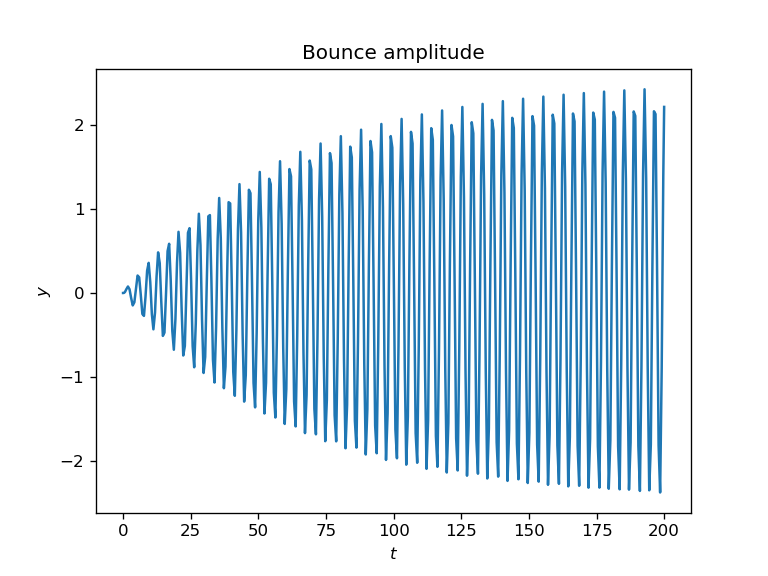

In [9]:
from scipy.integrate import solve_ivp
%matplotlib nbagg

mu=3 #guessed from a non-driven system so that a 1m amplitude decreases to 0.5m in one minute
omega0 = (2*np.pi)/T
zeta = mu/(2*np.sqrt(m*k))
comshift = 0.4 # shift of the COM in meters during bouncing
ad = comshift/omega0/omega0 
omegad = omega0
y0 = [0,0]
def f(t,y):
    return [y[1],ad*np.sin(omegad*t)-omegad**2*y[0]-2*zeta*omegad*y[1]]

t_span = [0, 200]
sol1 = solve_ivp(f, t_span, y0)
t=sol1.t
y=sol1.y[0]

plt.title("Bounce amplitude") 
plt.xlabel("$t$") 
plt.ylabel("$y$") 
plt.plot(t,y) 
plt.show()
